### Part4: Coincidence detection with AMPA-like and NMDA-like synapses

Coincidence detection can be emulated on the chip by exploiting the non-linear properties of the NMDA-like DPI circuit block, 
which mimics the biological NMDA voltage-gating dynamics, combined with the AMPA-like DPI circuit. 

<img src="img/synapse.png" alt="Synapse circuit." style="width: 400px;">

The above schematic shows a typical silicon synapse circuit implemented on Dynap-SE1. As mentioned in Part1, the green and yellow blocks can be modeled with the following equation:

$$\tau \frac{d}{d t} I_{s y n}(t)+I_{s y n}(t)=I_{w} \delta\left(t_{p r e}\right)$$

where $I_{s y n}$ is the synaptic current, $I_{w}$ is the gain factor (weight) of the synapse, and $\tau$ is time constant of current decay.

These blocks are used to mimic the fast AMPA-like dynamics, with: 

$$ I_{s y n,ampa}=I_{s y n}$$

The output differential pair (red block), instead, implements the NMDA-like voltage-gated channels, with:

$$ I_{s y n,nmda}(t) =  \frac{I_{s y n}(t)}{1 + exp(\frac{k_n (V_{nmda}-V_{mem})}{U_T})}$$

where $V_{mem}$ is the voltage across the neuron’s membrane capacitance $C_{mem}$:

$$ V_{mem} = \frac{U_T}{\kappa} log(\frac{I_{mem}}{I_o}) + V_s $$

with $V_s$ being the source voltage of the output transistor, i.e. the drain voltage of the diode connected transistor MA4 in the neuron circuit.

<img src="img/neuron.png" alt="Neuron circuit." style="width: 400px;">

For more detailed explanations of neural and synaptic circuits (and especially the derivations and the assumptions behind the formulas mentioned) you can check [PDF available on arXiv.](https://arxiv.org/pdf/1403.6428.pdf)

>Chicca, E., Stefanini, F., Bartolozzi, C., Indiveri, G. (2014). Neuromorphic Electronic Circuits for Building Autonomous Cognitive Systems Proceedings of the IEEE  102(9), 1367-1388.


By combining one AMPA-like and one NMDA-like DPI circuit, we will now show an example of coincidence detection that can be emulated on Dynap-SE1.

Let's start with importing Brian2:

In [1]:
from brian2 import *
from DynapSE import DynapSE
from parameters.constants import *

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from parameters.set_params import set_params

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90 

from equations.dynapse_eq import *
from parameters.dynapse_param import *

# C++ code generation for faster spiking network simulation
set_device('cpp_standalone')
# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

# Reinitialize the device
device.reinit()
device.activate()

### Input Spike Train

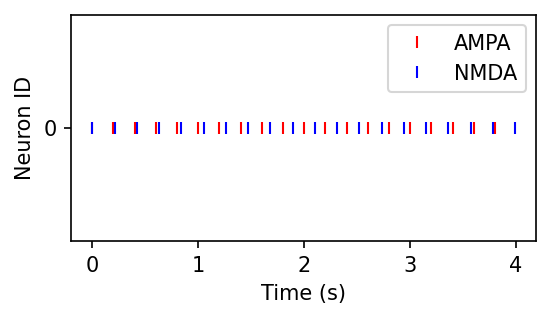

In [2]:
num_spikes = 20
rate = 5            # Hz
inp_duration = num_spikes/rate # second
spikes = np.zeros(int(inp_duration*1000))
dt = int(1000/rate)
end = int(inp_duration*1000)
spikes[0:end:dt] = 1.0
spike_timing_ampa = np.where(spikes==1)[0] * ms # Timing of spikes
spike_timing_nmda = np.array([spike_timing_ampa[idx]/ms+idx*10 for idx in range(len(spike_timing_ampa))])*ms

neuron_indices_nmda = np.zeros(len(spike_timing_nmda)) # ID of spike sources
neuron_indices_ampa = np.zeros(len(spike_timing_ampa)) # ID of spike sources

# Merging AMPA-NMDA
neuron_indices = np.array(list(neuron_indices_nmda) + list(neuron_indices_ampa))
spike_times = np.array(list(spike_timing_nmda) + list(spike_timing_ampa))

# Sorting
ids = np.argsort(spike_times)
spike_times = spike_times[ids]*second
neuron_ids = neuron_indices[ids]

# Spike Generator
input_spike_generator_ampa = SpikeGeneratorGroup(1, indices=neuron_indices_ampa, times=spike_timing_ampa, name='InpAMPA')  
input_spike_generator_nmda = SpikeGeneratorGroup(1, indices=neuron_indices_nmda, times=spike_timing_nmda, name='InpNMDA')  

# Plot
plt.figure(figsize=(4,2),dpi=150)
plt.plot(spike_timing_ampa, neuron_indices_ampa, 'r|', label='AMPA')
plt.plot(spike_timing_nmda, neuron_indices_nmda, 'b|', label='NMDA')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Neuron ID")
plt.ylim(-0.25, .25)
plt.yticks([0])
plt.show()

### Brian2 Network

In [3]:
network = Network() # Instantiate a Brian2 Network
chip = DynapSE(network) # Instantiate a Dynap-SE1 chip implementing neural and synaptic silicon dynamics

# Overwrite default pameters:
dynapse_param['I_wo_syn_nmda'] = 100. * pA
dynapse_param['I_wo_syn_ampa'] = 75. * pA
dynapse_param['Ith'] = 3 *pA
dynapse_param['Itau'] = 2 *pA
dynapse_param["Ispkthr"] = 1 *nA
dynapse_param["I_tau_syn_nmda"] = 2 *pA
dynapse_param["I_g_syn_nmda"] = .8 *pA
dynapse_param["Vnmda"] = 800*mV

for core in chip.cores:
    set_params(core.neurons, dynapse_param)

Now we will connect our spike generator groups to one target neuron, via one AMPA-like and one NMDA-like DPI circuit. 

In [4]:
DPI_neuron  = chip.get_neurons(1, 'Core_1') # Allocate single DPI neuron from Core 1
DPI_AMPA_synapse = chip.add_connection(input_spike_generator_ampa, DPI_neuron, synapse_type='AMPA') # Define a slow excitatory synapse
DPI_NMDA_synapse = chip.add_connection(input_spike_generator_nmda, DPI_neuron, synapse_type='NMDA') # Define a fast excitatory synapse

# In Brian2 creating Synapses instance does not connect two endpoints, it only specifies synaptic dynamics 
# Let's connect two endpoints and set an initial weight of 300.

chip.connect(DPI_NMDA_synapse, True)
DPI_NMDA_synapse.weight = 1000


chip.connect(DPI_AMPA_synapse, True)
DPI_AMPA_synapse.weight = 500

1 neurons are allocated from Core_1.


### Run simulation

In [5]:
# Monitors
mon_neuron_input_ampa  = SpikeMonitor(input_spike_generator_ampa, name='mon_neuron_input_ampa')
mon_neuron_input_nmda  = SpikeMonitor(input_spike_generator_nmda, name='mon_neuron_input_nmda')
mon_synapse_nmda  = StateMonitor(DPI_NMDA_synapse, 'I_syn_nmda', record=[0])
mon_synapse_ampa  = StateMonitor(DPI_AMPA_synapse, 'I_syn_ampa', record=[0])
mon_neuron_state  = StateMonitor(DPI_neuron, 'Imem', record=True)
mon_neuron_vmem  = StateMonitor(DPI_neuron, 'Vmem', record=True)
#mon_neuron_vmem_clip  = StateMonitor(DPI_neuron, 'Vmem_clip', record=True)
mon_neuron_I_syn_nmda  = StateMonitor(DPI_neuron, 'I_syn_nmda_dp', record=True)
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')

# Add every instance we created to Brian network, so it will include them in the simulation
network.add([input_spike_generator_ampa, input_spike_generator_nmda, DPI_neuron, DPI_NMDA_synapse, 
             DPI_AMPA_synapse, mon_neuron_input_ampa, mon_neuron_input_nmda, mon_synapse_nmda, 
             mon_synapse_ampa, mon_neuron_output, mon_neuron_state, mon_neuron_vmem, mon_neuron_I_syn_nmda])

# Simulation
duration = inp_duration * 1000 * ms
network.run(duration)

WARNING    "Io" is an internal variable of group "Core_0", but also exists in the run namespace with the value 0.5 * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Ut" is an internal variable of group "Core_0", but also exists in the run namespace with the value 25. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Io" is an internal variable of group "Core_1", but also exists in the run namespace with the value 0.5 * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Ut" is an internal variable of group "Core_1", but also exists in the run namespace with the value 25. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Io" is an internal variable of group "Core_2", but also exists in the run namespace with the value 0.5 * pamp. The internal va

In [6]:
# Print parameters
print('I_tau_syn AMPA: {}'.format(DPI_AMPA_synapse.I_tau_syn_ampa))
print('I_tau_syn NMDA: {}'.format(DPI_NMDA_synapse.I_tau_syn_nmda))

kappa = (kappa_n + kappa_n) / 2
tau_ampa = DPI_AMPA_synapse.C_syn_ampa * Ut /(kappa_p * DPI_AMPA_synapse.I_tau_syn_ampa)
tau_nmda = DPI_AMPA_synapse.C_syn_nmda * Ut /(kappa_p * DPI_AMPA_synapse.I_tau_syn_nmda)
tau = (DPI_neuron.Cmem * Ut) / (kappa * DPI_neuron.Itau)

print('Tau AMPA: {}'.format(tau_ampa))
print('Tau NMDA: {}'.format(tau_nmda))
print('Tau neuron: {} sec'.format(tau))

I_tau_syn AMPA: <AMPA0.I_tau_syn_ampa: array([50.]) * pamp>
I_tau_syn NMDA: <NMDA1.I_tau_syn_nmda: array([2.]) * pamp>
Tau AMPA: [1.13636364] ms
Tau NMDA: [28.40909091] ms
Tau neuron: 0.025 sec


Notice that the neuron and the synapse leakage were set such that:

$$ \tau_{AMPA} <\tau < \tau_{NMDA}$$


### Plot results

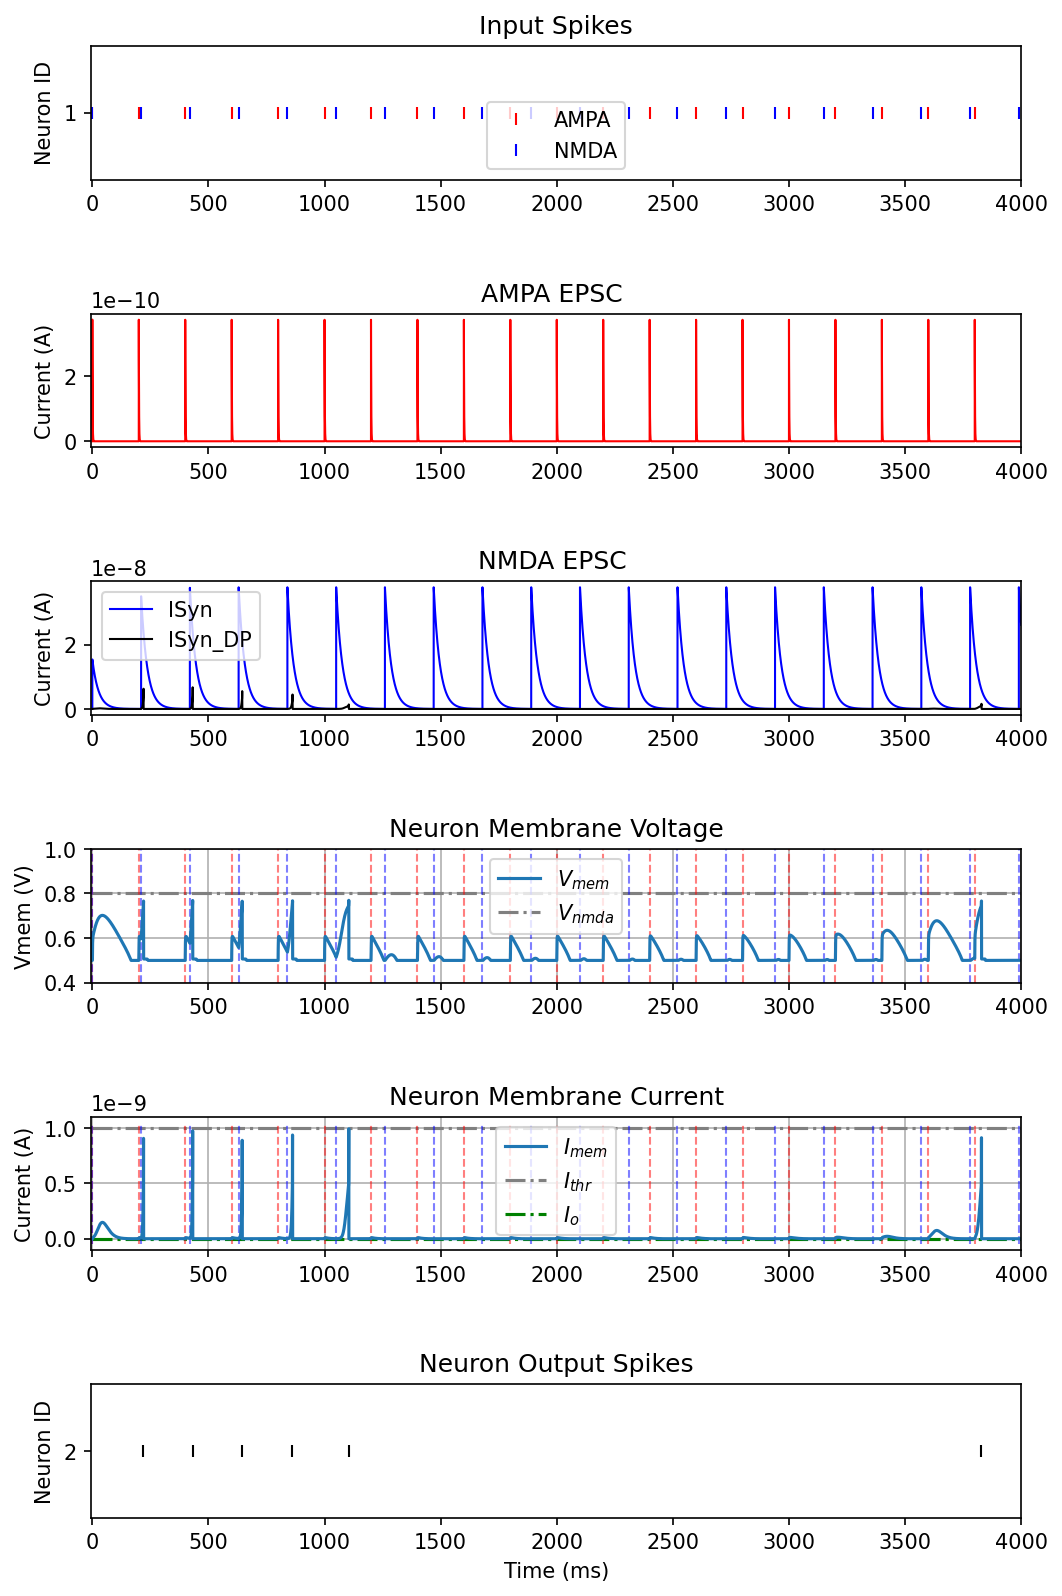

In [7]:
f = plt.figure(figsize=(8,13),dpi=150)
plt.subplots_adjust(hspace=1)
tstart = 0
tend   = int(inp_duration*1000) # ms

# Input Spikes 
plt.subplot(611)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input_ampa.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'r|', label='AMPA')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input_nmda.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'b|', label='NMDA')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.legend()
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
plt.xlim(-5, duration/ms)
#plt.xlabel('Time (ms)')

plt.subplot(612)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1, c='r')
plt.xlim(-5, duration/ms)
plt.ylabel('Current (A)')
plt.title('AMPA EPSC ')

plt.subplot(613)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_nmda.I_syn_nmda[0][tstart*s:tend*s], linewidth=1, label='ISyn', c='b')
plt.plot(mon_neuron_I_syn_nmda.t[tstart*s:tend*s]/ms, mon_neuron_I_syn_nmda.I_syn_nmda_dp[0][tstart*s:tend*s], linewidth=1, c='k', label='ISyn_DP')
plt.legend()
plt.xlim(-5, duration/ms)
plt.ylabel('Current (A)')
plt.title('NMDA EPSC ')

plt.subplot(614)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_neuron_vmem.Vmem[0][tstart*s:tend*s], linewidth=1.5)
plt.hlines(y=dynapse_param['Vnmda'], xmin=tstart, xmax=tend, color='grey', linestyles='-.')
plt.legend(['$V_{mem}$', '$V_{nmda}$'])
plt.ylim(.4, 1)
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=1)
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=1)
plt.title('Neuron Membrane Voltage')
plt.ylabel('Vmem (V)')
plt.xlim(-5, duration/ms)
plt.grid(True)

plt.subplot(615)
Imem = mon_neuron_state.Imem[0]
plt.plot(mon_neuron_state.t/ms, Imem)
plt.hlines(y=dynapse_param['Ispkthr']*1e-9/nA, xmin=tstart, xmax=tend, color='grey', linestyles='-.')
plt.hlines(y=dynapse_param['Io'] /pA *1e-12, xmin=tstart, xmax=tend, color='green', linestyles='-.')
plt.legend(['$I_{mem}$', '$I_{thr}$', '$I_o$'])
plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
plt.xlim(-5, duration/ms)
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=1)
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=1)
plt.grid(True)

plt.subplot(616)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.xlim(-5, duration/ms)
plt.show()

#f.savefig('./DPI_coincidenceDetection.pdf')